# Rechord

## Automatic sheet music composition

Import libraries:
pip install numpy pyaudio scipy music21

In [1]:
import numpy as np
import pyaudio
import struct
from scipy.fftpack import fft
import music21 # install musescore

In [2]:
def display(key, hz, notes):
    note = scale[(key - 1) % 12] + str((key+8) // 12) # note as string
    notes.append(note)

    print(note, '\t', hz)

### Functions

Transpose notes to sheet music using music21

In [3]:
def transcribe(notes): # optimize length algorithm
    for i, note in enumerate(notes):
        if len(note) > 1:
            octave = int(note[-1])

            if octave == 0:
                notes[i] = note[:-1].upper() * 4
            elif octave == 1:
                notes[i] = note[:-1].upper() * 3
            elif octave == 2:
                notes[i] = note[:-1].upper() * 2
            elif octave == 3:
                notes[i] = note[:-1].upper()
            elif octave == 4:
                notes[i] = note[:-1].lower()
            elif octave == 5:
                notes[i] = note[:-1].lower() + "'"
            elif octave == 6:
                notes[i] = note[:-1].lower() + "'" * 2
            elif octave == 7:
                notes[i] = note[:-1].lower() + "'" * 3
            elif octave == 8:
                notes[i] = note[:-1].lower() + "'" * 4
        else:
            continue

    music = []
    nps = 12 # in 1 second, the program records 12 notes
    i = j = 0
    while i < len(notes):
        try:
            if notes[i] == notes[j]:
                j += 1
            else:
                dur = str(min([1,2,4,8,16,32], key=lambda x:abs(x-(round(1 / (j - i) * nps)))))
                music.append(notes[i] + dur)
                i = j
        except IndexError:
            dur = str(min([1,2,4,8,16,32,64], key=lambda x:abs(x-(round(1 / (j - i) * nps)))))
            music.append(notes[i] + dur)
            i = j
            i += 1

    # octave: 0, CCCC | 1, CCC | 2, CC | 3, C | 4, c| 5, c' | 6, c'' | 7, c''' | 8, c'''' |
    # print("music21.converter.parse(\"tinynotation: 4/4 " + " ".join(music) + "\").show()")
    music21.converter.parse("tinynotation: 4/4 " + " ".join(music)).show()

Convert frequencies to keys

In [4]:
def conv(fs):
    fs_max = -np.sort(-fs)

    key = None
    i = 0
    while not key:
        i += 1
        hz = round((np.where(fs == fs_max[i])[0][0]) * RATE / CHUNK) # convert FFT to hz
        note = int(round(12 * np.log2(hz/440) + 49)) # hz to note on piano

        if note > 0 and note < 109:
            key = note
    
    return key, hz

Audio input stream function

In [5]:
def record(rests = True):
    notes = []
    
    print("stream started\n")

    try:
        while True:
            data = stream.read(CHUNK, exception_on_overflow=False)
            data_int = struct.unpack(str(2 * CHUNK) + 'B', data)
            data_np = np.array(data_int, dtype='b')[::2] + 128

            if np.percentile(np.abs(data_np), 90) >= 200: # check volume if a note is being played
                # compute FFT and update line
                fs = np.abs(fft(data_int)[0:CHUNK])

                key, hz = conv(fs)
                display(key, hz, notes)
            elif rests and len(notes) > 1:
                notes.append('r')
                # continue

    except KeyboardInterrupt:
        p.close(stream)
        print("\n\nstream ended\n\n")
    
    return notes

Define variable constants

In [6]:
# stream constants
CHUNK = 1024 * 2
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 22050

# stream object
p = pyaudio.PyAudio()
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    output=True,
    frames_per_buffer=CHUNK,
)

scale = ["a", "a#", "b", "c", "c#", "d", "d#", "e", "f", "f#", "g", "g#"]

### Conversion program

Record audio and transcribe frequencies to sheet music

In [7]:
notes = record(rests=False) # interrupt to end stream

stream started

d4 	 291.0
d4 	 291.0
d4 	 291.0
d4 	 291.0
d4 	 291.0
d4 	 291.0
g4 	 388.0
g4 	 388.0
g4 	 388.0
g4 	 388.0
g4 	 388.0
g4 	 398.0
b4 	 495.0
b4 	 495.0
b4 	 495.0
b4 	 495.0
b4 	 495.0
b4 	 495.0
b4 	 495.0
b4 	 495.0
b4 	 495.0


stream ended




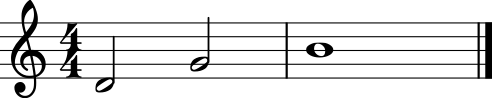

In [9]:
transcribe(notes)